## Importing the required libraries

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import xgboost as xgb
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

Reading the Dataset

In [2]:
house_data = pd.read_csv("Bengaluru_House_Data.csv")

Shape of the Datset

In [3]:
house_data.shape

(13320, 9)

Top 5 rows of the data

In [4]:
house_data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


Grouping the data by the area_type and finding out the count of the types of area_type

In [6]:
house_data.groupby("area_type")["area_type"].agg("count")

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [15]:
def categorical_plot(feature, data):
    _, ax = plt.subplots(1, 2, figsize=(12, 4))
    data[feature].value_counts().plot(kind="pie", explode=[0.05 for _ in data[feature].dropna().unique()], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(f"{feature} Pie Chart")
    ax[0].set_ylabel('')

    count = sns.countplot(x=feature, data=data, ax=ax[1])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{feature} Bar Chart")
    plt.show()

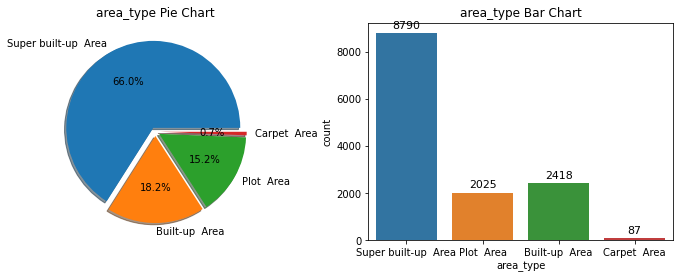

In [16]:
categorical_plot("area_type", house_data)

In [17]:
house_df = house_data.drop(["availability", "area_type", "society"], axis="columns")
house_df.head()

,location,size,total_sqft,bath,balcony,price
0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [18]:
house_df.isnull().sum()

location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

In [19]:
house_df = house_df.drop(["balcony"], axis=1)

In [20]:
house_df_ = house_df.dropna()
house_df_.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [21]:
house_df_['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [23]:
house_df_["BHK"] = house_df_["size"].apply(lambda x: int(x.split()[0]))

In [24]:
house_df_.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [25]:
house_df_.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [26]:
house_df_[house_df_.BHK > 20]

,location,size,total_sqft,bath,price,BHK
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [27]:
def is_float(x):
    try:
        float(x)
    except Exception:
        return False
    return True

In [28]:
house_df_[~house_df_['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,BHK
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [29]:
def convert_sqft_to_num(sqft):
    tokens = sqft.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(sqft)
    except:
        return None

In [30]:
df = house_df_.copy()

In [31]:
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

In [32]:
df['total_sqft']

0        1056.0
1        2600.0
2        1440.0
3        1521.0
4        1200.0
          ...  
13315    3453.0
13316    3600.0
13317    1141.0
13318    4689.0
13319     550.0
Name: total_sqft, Length: 13246, dtype: float64

In [33]:
df.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
BHK                   4
Name: 30, dtype: object

In [34]:
df

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4


In [35]:
df1 = df.copy()
df1['price_per_sqft'] = df1['price'] * 100000 / df1['total_sqft']

In [36]:
df1

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


In [37]:
df1.location.unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [38]:
len(df1.location.unique())

1304

In [39]:
df1.location = df1.location.apply(lambda x: x.strip())
loc_stats = df1.groupby("location")["location"].agg('count').sort_values(ascending=False)
loc_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [40]:
len(loc_stats[loc_stats <= 10])

1052

In [42]:
loc_stats_less_than_10 = loc_stats[loc_stats <= 10]

In [43]:
df1.location = df1.location.apply(lambda x: 'other' if x in loc_stats_less_than_10 else x)
len(df1.location.unique())

242

In [46]:
df2 = df1[~(df1.total_sqft / df1.BHK < 300)]
df2.shape

(12502, 7)

In [47]:
df2.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [48]:
import numpy as np
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [49]:
df3 = remove_pps_outliers(df2)

In [50]:
df3.shape

(10241, 7)

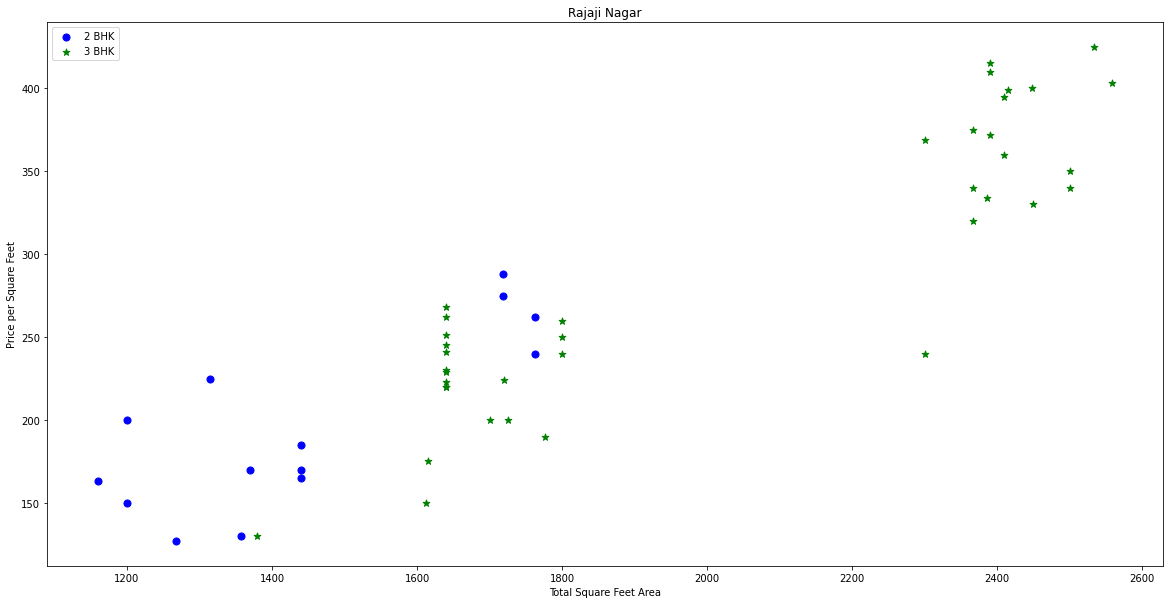

In [51]:
def plot_scatter(df, location):
    bhk2 = df[(df.location == location) & (df.BHK == 2)]
    bhk3 = df[(df.location == location) & (df.BHK == 3)]
    plt.scatter(bhk2.total_sqft, bhk2["price"], color="blue", label="2 BHK", s=50)
    plt.scatter(bhk3.total_sqft, bhk3["price"], color="green", label="3 BHK", s=50, marker='*')
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price per Square Feet")
    plt.title(location)
    plt.legend()

plot_scatter(df3, "Rajaji Nagar")

In [52]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for loc, loc_df in df.groupby('location'):
        bhk_stats = {bhk: {'mean': np.mean(bhk_df.price_per_sqft), 'std': np.std(bhk_df.price_per_sqft), 'count': bhk_df.shape[0]} for bhk, bhk_df in loc_df.groupby('BHK')}

        for bhk, bhk_df in loc_df.groupby('BHK'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis ='index')     
        

In [53]:
df4 = remove_bhk_outliers(df3)
df4.shape

(7329, 7)

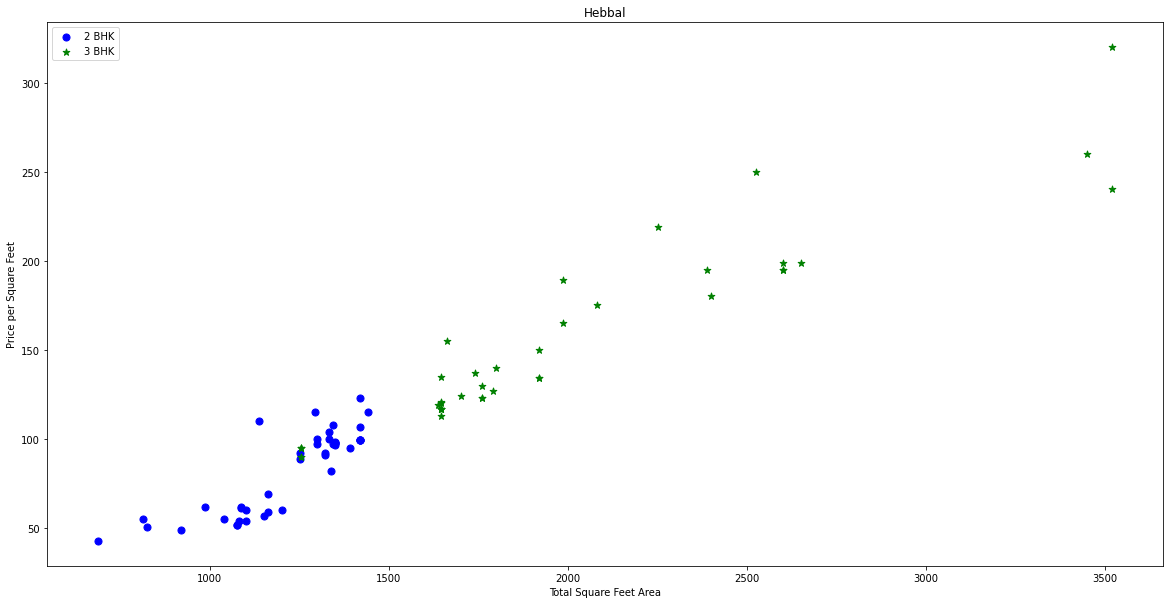

In [54]:
plot_scatter(df4, "Hebbal")

Text(0, 0.5, 'Count')

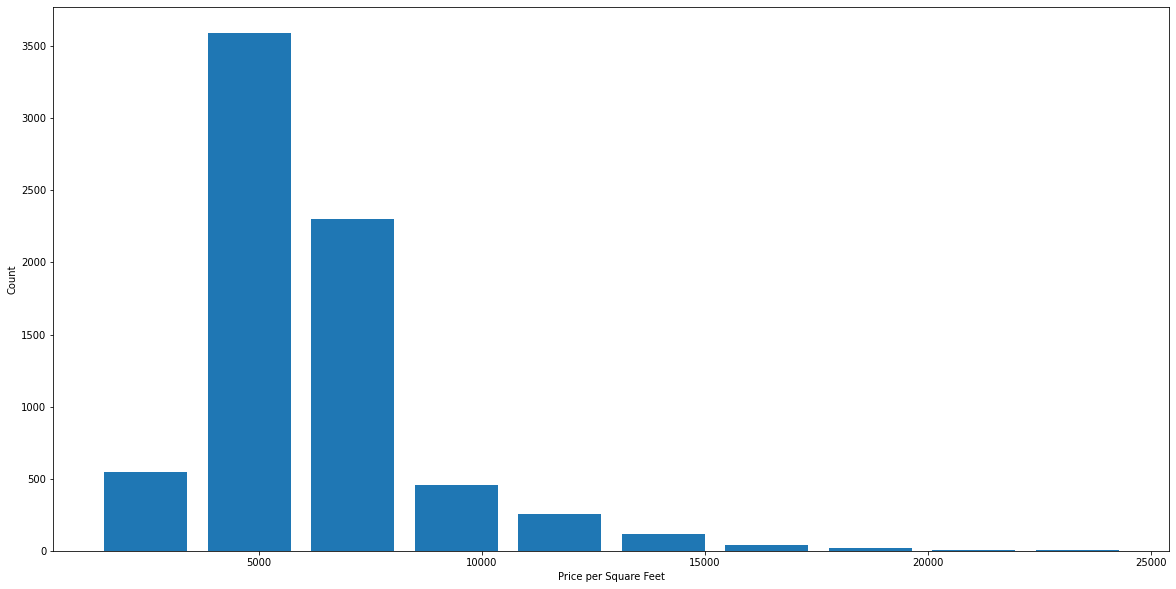

In [55]:
plt.hist(df4.price_per_sqft, rwidth = 0.8)
plt.xlabel("Price per Square Feet")
plt.ylabel("Count")

In [56]:
df5 = df4[~(df4.bath >= df4.BHK + 2)]
df5.shape

(7251, 7)

In [57]:
df6 = df5.drop(['size', 'price_per_sqft'], axis='columns')
df6.head()

,location,total_sqft,bath,price,BHK
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [58]:
dummies = pd.get_dummies(df6.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df7 = pd.concat([df6, dummies.drop('other', axis = 'columns')], axis='columns')
df7.head(4)

,location,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
df8 = df7.drop('location', axis = 'columns')
df8.head(3)

,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
X = df8.drop(['price'], axis='columns')
X.head()

,total_sqft,bath,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
Y = df8['price']
Y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)


array([[1.564e+03, 3.000e+00, 3.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.200e+03, 4.000e+00, 4.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.444e+03, 4.000e+00, 4.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [9.500e+02, 2.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.000e+03, 8.000e+00, 8.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [9.000e+02, 2.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [64]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression(normalize=True)
lr_model.fit(X_train, Y_train)
lr_model.score(X_test, Y_test)

0.8452277697873782

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

In [70]:
def find_best_model():
    algos = {
        'linear_regression':{
            'model': LinearRegression(),
            'params':{
                'normalize':[True, False]
            }
        },
        'lasso':{
            'model': Lasso(),
            'params':{
                'alpha': [1, 2, 3, 4, 5]
            }
        },
        'ridge':{
            'model': Ridge(),
            'params':{
                'alpha': [1, 2, 3, 4, 5]
            }
        },
        'decision_tree':{
            'model': DecisionTreeRegressor(),
            'params':{
                'splitter': ['best', 'random'],
                'criterion': ['squared_error', 'friedman_mse'],
                'max_depth': [20, 25, 30, 35, 40]
            }
        },
        'xg_boost':{
            'model': xgb.XGBRegressor(),
            'params':{
                'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
            }
        }
    }
    scores = []
    best_estimators = {}
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=5, return_train_score=False)
        gs.fit(X_train.values, Y_train)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        best_estimators[algo_name] = gs.best_estimator_
    return best_estimators, pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [71]:
best_estimators, models = find_best_model()

In [72]:
models

,model,best_score,best_params
0,linear_regression,0.832471,{'normalize': False}
1,lasso,0.689078,{'alpha': 1}
2,ridge,0.830957,{'alpha': 1}
3,decision_tree,0.745591,"{'criterion': 'friedman_mse', 'max_depth': 20,..."
4,xg_boost,0.816808,{'learning_rate': 0.5}


In [73]:
best_estimators['linear_regression'].score(X_test.values, Y_test)

0.8452277697874323

In [77]:
best_estimators['xg_boost'].score(X_test.values, Y_test)

0.8470916999583944

In [74]:
best_estimators['lasso'].score(X_test.values, Y_test)

0.7237775279429011

In [75]:
best_estimators['ridge'].score(X_test.values, Y_test)

0.8439897449096889

In [76]:
best_estimators['decision_tree'].score(X_test.values, Y_test)

0.7622825182628734

In [79]:
import pickle

In [80]:
with open("banglore_houses_model.pickle", 'wb') as f:
    pickle.dump(best_estimators['xg_boost'], f)

In [74]:
import json
columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))